In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle as pk
import numpy as np
import sklearn.manifold as man
from tensorflow.python.framework import ops
import emoji
import sys
sys.path.append("../../emoji2vec_working/")
from phrase2vec import Phrase2Vec
from utils import build_kb, get_examples_from_kb, generate_embeddings, get_metrics
import pandas as pd
import gensim.models as gs
from pathlib import Path
from src.constants import emotions_faces,REF_PATH,MAPPING_PATH, E2V_PATH, W2V_PATH, DATA_PATH
import gensim.models as gs
import warnings
from scipy.stats import hmean
from scipy import spatial

warnings.filterwarnings("ignore")


/home/ymentha/Documents/Cours/dlab_project/emojivec/env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ymentha/Documents/Cours/dlab_project/emojivec/env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ymentha/Documents/Cours/dlab_project/emojivec/env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16"

## Data Loading/Cleaning

In [3]:
# mapping from id to emoji
mapping = pk.load(open(MAPPING_PATH, 'rb'))
# mapping from emoji to id
inv_map = {v: k for k, v in mapping.items()}

phraseVecModel = Phrase2Vec.from_word2vec_paths(300, W2V_PATH, E2V_PATH)
e2v = phraseVecModel.emojiVecModel
w2v = phraseVecModel.wordVecModel

In [4]:
form1_df = (pd.read_csv("../forms/emoji10/Emojis Description.csv")
              .set_index('Worker ID'))
form1_df = (form1_df.rename(columns={col_name:col_name.strip() for col_name in form1_df.columns})
              .drop(columns=["Timestamp"]))

<div class="alert alert-success"> 
Some entries are filled randomly as can be seen in the following
</div>

In [5]:
form1_df.loc[["A3NKJAX21PSNWD","A2JC65REBH7706"]]

,🙂,😍,😀,😄,🤣,🤭,👿,🤔,🤯,😭
Worker ID,,,,,,,,,,
A3NKJAX21PSNWD,"star,blank,question","love,joy,enjou","smile,happy,enjoy","smile,happy,enjoy","blank,empty,thinking","blank,empty,thinking","angery,tension,avoid","blank,empty,thinking","blank,empty,thinking","funny,sad,feel"
A2JC65REBH7706,"sick,ill,unwell","love,smile,heart","fun,laughing,lol","happy,smiling,fun","sick,ill,unwell","sick,ill,unwell","monster,danger,angry","sick,ill,unwell","sick,ill,unwell","sad,cry,worry"


In [6]:
form1_df.drop(["A3NKJAX21PSNWD","A2JC65REBH7706"],inplace=True)

## Feature Extraction

In [7]:
def user_representation(formdf):
    """
    represent an emoji from a specific user by summing the answer representations together
    
    Args:
        formdf (pd.DataFrame): the data as received in the formular
        emoji (string): emoji to 
    """
    df = formdf.transpose().copy()
    em_reps = []
    for em,row in df.iterrows():
        new_row = [em]
        em_rep = []
        for word3 in row:
            rep3 = []
            for word in word3.split(","):
                try:
                    wordvec = w2v.get_vector(word)
                    rep3.append(wordvec)
                except KeyError:
                    pass
            if len(rep3) > 0:
                rep3 = np.sum(rep3,axis=0)
                em_rep.append(rep3)
        new_row.append(np.array(em_rep))
        em_reps.append(new_row)

    em_reps = (pd.DataFrame(em_reps,columns=["em","reps"])
               .set_index('em'))
    return em_reps

In [8]:
def unif_representation(form1_df):
    """
    represent an emoji by the sum of each word answers'vector
    """
    df = form1_df.transpose().copy()
    em_reps = []
    for em,row in df.iterrows():
        new_row = [em]
        em_rep = []
        for word3 in row:
            for word in word3.split(","):
                try:
                    wordvec = w2v.get_vector(word)
                    em_rep.append(wordvec)
                except KeyError:
                    pass
        new_row.append(np.array(em_rep))
        em_reps.append(new_row)

    em_reps_df = (pd.DataFrame(em_reps,columns=["em","reps"])
               .set_index('em'))
    return em_reps_df

In [9]:
user_df = user_representation(form1_df)
unif_df = unif_representation(form1_df)

## Clustering assessment

<div class="alert alert-success"> 
We try to assess how clustered/centered the data is in the small dataset we received.
</div>

In [10]:
def compute_det(df):
    """
    compute the determinant of the correlation matrix for each emoji
    """
    df['det'] = df['reps'].apply(lambda x:np.linalg.det(np.corrcoef(x)))

In [11]:
compute_det(user_df)
compute_det(unif_df)

In [12]:
def print_det(df):
    """
    print the determinant
    """
    df = df.sort_values('det')
    fig,ax = plt.subplots(1)
    ax.set_title("Determinant of correlation matrix amongst crowdsourced words vectors")
    df['det'].plot.bar()
    fig.show()
    print("Emojis:",end="")
    for i in df.index:
        print(i,end=" ")

TODO: len(set(words used for the given emoji))

Emojis:😭 🤣 😍 😀 🙂 👿 😄 🤯 🤭 🤔 

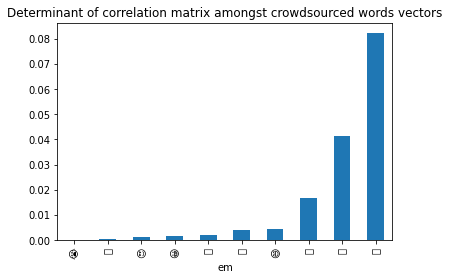

In [13]:
print_det(user_df)

Emojis:🤔 🙂 😍 😀 😄 🤣 👿 🤯 😭 🤭 

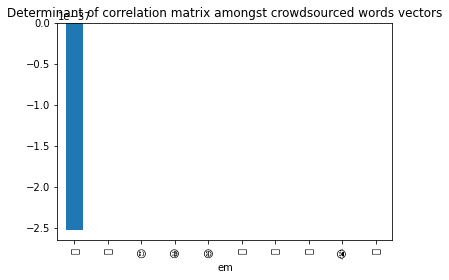

In [14]:
print_det(unif_df)

## Correlations with emoji2vec

<div class="alert alert-success"> 
We compute the correlation between the feature space created by taking the mean/median of the vectors corresponding to the crowd-sourced words: this allow us to check for which emoji a divergence can be observed
</div>

In [15]:
user_df = user_df[user_df.index.isin(emotions_faces)]
unif_df = unif_df[unif_df.index.isin(emotions_faces)]

In [16]:
def compute_em2v_vecs(df):
    """
    add the emoji2vec representation, the mean/median rep of the crowdsourced data
    along with the corresponding correlations    
    """
    df['em2vec_rep'] = df.index.map(lambda x: e2v.get_vector(x))
    
    # mean representation of the crowdsourced vectors
    df['mean_rep'] = df['reps'].apply(lambda x: np.mean(x,axis=0))
    df['corr_mean'] = df[['mean_rep','em2vec_rep']].apply(lambda x:np.corrcoef(x[0],x[1])[0,1],axis=1)
    
    # median representation of the crowdsourced vectors
    df['median_rep'] = df['reps'].apply(lambda x: np.median(x,axis=0))
    df['corr_median'] = df[['median_rep','em2vec_rep']].apply(lambda x:np.corrcoef(x[0],x[1])[0,1],axis=1)

In [17]:
compute_em2v_vecs(user_df)
compute_em2v_vecs(unif_df)

In [18]:
def plot_corr(df,agg_type="mean"):
    """
    plot the emojis along with the correlation of their
    mean/median representation
    """
    df = df.sort_values(f'corr_{agg_type}')
    fig,ax = plt.subplots(1)
    ax.set_title(f"Correlations between {agg_type} of crowdsourced rep and emojivec rep")
    df[f'corr_{agg_type}'].plot.bar()
    fig.show()
    print("Emojis:",end="")
    for i in df.index:
        print(i,end=" ")

Emojis:🤔 🤣 👿 🙂 😀 😄 😍 😭 

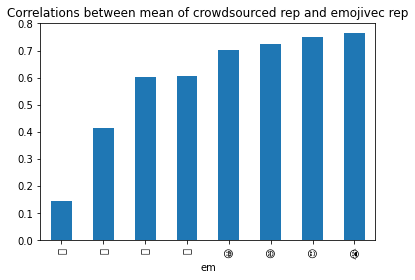

In [19]:
plot_corr(user_df)

Emojis:🤔 🤣 👿 🙂 😀 😄 😍 😭 

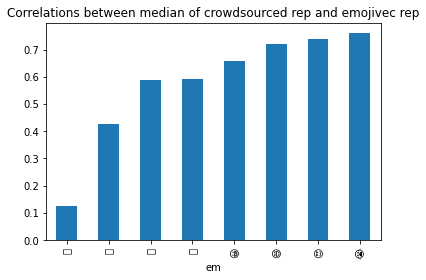

In [20]:
plot_corr(user_df,agg_type="median")

Emojis:🤔 🤣 👿 🙂 😀 😄 😍 😭 

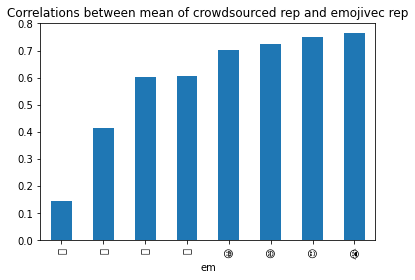

In [21]:
plot_corr(unif_df,agg_type="mean")

## Top representative words

<div class="alert alert-success"> 
We now try to assess which word is the closest to each emoji in the vector space in order <b>to better grasp the emotional representation of each emoji for the users.</b>
</div>

In [22]:
def get_words_scores(form1_df,user_df,col="mean_rep"):
    """
    return the words appearing with each emoji along with the cosine similarity and the correlation
    with the emoji in question
    """
    words_scores_df = form1_df.transpose().agg(",".join,axis=1)

    words_scores_df = (words_scores_df.apply(lambda x: list(set(x.split(","))))
                         .reset_index()
                         .rename(columns={0:'word','index':'em'}))

    words_scores_df = words_scores_df.explode("word")

    # we keep the words that are present in the vocabulary of word2vec
    words_scores_df = words_scores_df[words_scores_df.word.isin(w2v.vocab)]
    # extract the word vectors
    words_scores_df['wordvec'] = words_scores_df['word'].apply(lambda word: w2v.get_vector(word))

    words_scores_df = pd.merge(words_scores_df,user_df[col],on='em',how='inner')
    words_scores_df['word_corr'] = words_scores_df[['wordvec',col]].apply(lambda x:np.corrcoef(x[0],x[1])[0,1],axis=1)

    words_scores_df['word_cossim'] = words_scores_df[['wordvec',col]].apply(lambda x:(1-spatial.distance.cosine(x[0], x[1])),axis=1)
    return words_scores_df

In [23]:
words_scores_meanvec_df = get_words_scores(form1_df,user_df)
words_scores_em2vec_df = get_words_scores(form1_df,user_df,col="em2vec_rep")

In [24]:
def print_best_words_emojis(words_scores_df,col='word_corr',em=None):
    """
    Plots the most correlated words alongs with the score for each emoji
    
    Args:
        words_scores_df (pd.DataFrame): as returned by get_words_scores
        col (str): metric of interest: either "word_corr" or "word_cossim"
        em (str): if specified, plots the scores only for this emoji
    """
    words_scores_df = words_scores_df.sort_values(['em',col],ascending=False)
    words_scores_df = words_scores_df.groupby('em')[['word',col]].agg(list)
    
    if em is not None:
        words_scores_df = words_scores_df[words_scores_df.index == em]
    print("Closest words in vector space:")
    for em,(words,words_corr) in words_scores_df[['word',col]].iterrows():
        print(f"Emoji{em}:")
        for word,word_corr in zip(words,words_corr):
            print(f"\t{word} {word_corr:.2f}")

In [25]:
def get_words_counts(form1_df,em):
    """
    Print the most common words in the crowdsourced data for the emoji
    passed in parameter
    
    Args:
        form1_df (pd.DataFrame): as defined above
        em (str): emoji of interest
    """
    print("Sorted most common words in crowdsourced data:")
    word_counts = pd.Series(form1_df
                  .transpose()
                  .agg(",".join,axis=1)
                  .loc[em]
                  .split(",")).value_counts()
    print(f"Emoji:{em}:")
    for word,count in word_counts.iteritems():
        print(f"\t{word} {count}")

In [26]:
def plot_best_words_emojis(words_scores_df,em,col='word_corr'):
    """
    Plots the most correlated words alongs with the score for each emoji
    
    Args:
        words_scores_df (pd.DataFrame): as returned by get_words_scores
        col (str): metric of interest: either "word_corr" or "word_cossim"
        em (str): if specified, plots the scores only for this emoji
    """
    words_scores_df = words_scores_df[words_scores_df['em'] == em]
    words_scores_df = words_scores_df.sort_values(['em',col],ascending=False)
    print(f"Emoji {em}:")
    fig,ax = plt.subplots(1,1)
    words_scores_df.plot.bar(ax=ax,x="word",y="word_corr")
    ax.set_title("Word Correlation between crowdsourced data and emoji")

Emoji2vec representation:
Emoji 🤔:


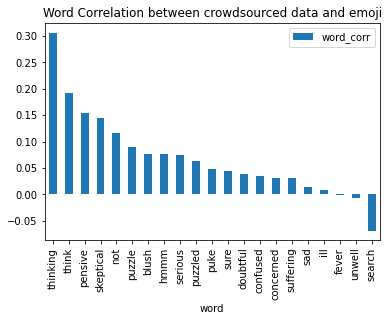

In [29]:
# list of emojis: 🙂😍😀😄🤣👿🤔😭
emoji_of_interest = "🤔"
print("Emoji2vec representation:")
plot_best_words_emojis(words_scores_em2vec_df,em=emoji_of_interest)

Mean Crowdsourced data representation:
Emoji 🤔:


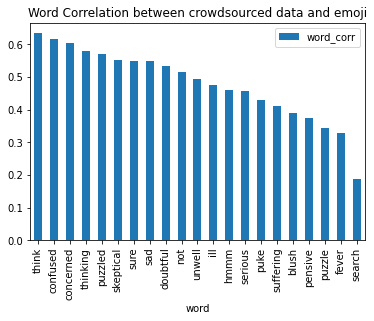

In [30]:
print("Mean Crowdsourced data representation:")
plot_best_words_emojis(words_scores_meanvec_df,em=emoji_of_interest)

<img src="../results/tsne/faces_tsne_words.jpeg"></div>